El objetivo es trucar la red neuronal **Inception V3** con un ataque adversario. Pero antes, probemos si funciona la red neuronal con una imágen.

In [1]:
import tensorflow as tf # plataforma para el aprendizaje automatico 
# Desabilitamos eager-execution por que peta cuando usemos más adelante keras.gradients()
tf.compat.v1.disable_eager_execution()
import keras # deep learning framework/api

import matplotlib.pyplot as plt
import numpy as np

In [3]:
from keras.applications.inception_v3 import InceptionV3, decode_predictions # importamos la red neuronal ya entrenada
from keras import backend as k

In [4]:
iv3 = InceptionV3() # Cargamos la red neuronal, la primera vez se descarga de internet

Instructions for updating:
Colocations handled automatically by placer.


In [26]:
# print(iv3.summary()) # Ver resumen de la red neuronal

from keras.preprocessing import image

# Para introducir la imágen a InceptionV3, la imagen requiere de unos requisitos
# Cargamos la imagen con dimension 299x299 (para iv3) y la convertimos a una matriz de datos
coche_2 = image.img_to_array(image.load_img("./img/coche_2.jpg", target_size=(299,299)))

# Cambiamos el rango o base, de [0-255] a [-1-1], por que
# así espera iv3 que pases los datos de la imágen
coche_2 /= 255
coche_2 -= 0.5
coche_2 *= 2

# La red neuronal espera que como entrada le pasemos un tensor,
# este tiene una dimensión más que la imágen que le pasamos,
# la primera dimensión hace referencia al tamaño del lote o "badge size?"
# esto es útil si queremos meter varias imágenes

coche_2 = coche_2.reshape([1, coche_2.shape[0], coche_2.shape[1], coche_2.shape[2]])

# LISTO, la variable ya esta lista para pasarsela al modelo
resultado = iv3.predict(coche_2)
decode_predictions(resultado)

[[('n04285008', 'sports_car', 0.8140701),
  ('n03459775', 'grille', 0.089450285),
  ('n02974003', 'car_wheel', 0.042520903),
  ('n03100240', 'convertible', 0.016252259),
  ('n04037443', 'racer', 0.0022947474)]]

Ahora, pasemos a romper el modelo con un `Ataque Adversario`. El objetivo es generar una imágen que truque a la red neuronal pero que a su vez, los cambios no sean perceptibles por el ojo humano. 

In [27]:
# Queremos hacer un grafo que represente un proceso de optimización en el que vamos a maximizar la probabilidad
# de que cierta clase aparezca. Queremos que prediga una clase concreta, del palo, le damos un gato
# y queremos que la red identifique que el gato es un limón. 

# Para ello solo necesitamos el punto de entrada y salida de la red neuronal:
input_layer = iv3.layers[0].input # Primera capa de la red neuronal, en concreto el punto de entrada
out_layer = iv3.layers[-1].output # Última capa de la red neuronal, el punto de salida vamos

target_class = 951 # Referencia a la clase limon (porque lo dice DotCSV)

# La función de coste es la probabilidad de la clase 951, osea, de todo el vector de probabilidades
# que devuelve le pedimos la fila 0, columna 951 que es el que nos interesa maximizar (el limon)
loss = out_layer[0, target_class]

# Gradiente sobre la variable de entrada, 
gradiente = k.gradients(loss, input_layer)[0] # Calcular el gradiente del coste respecto al tensor de entrada

# A estas funciones le suministramos los valores de entrada y salida, nuestra entrada es 
# el input_layer y le decimos también que estamos en la fase de entrenamiento y la salida
# es el gradiente y el coste.
optimize_gradient = k.function([input_layer, k.learning_phase()], [gradiente, loss])

copy_coche_2 = np.copy(coche_2) # Copia para no modificar la imágen original
cost = 0.0

# Minimicemos los cambios en la imágen para que no sean perceptibles
# por el ojo humano (de lo contrario apareceran pixeles muy saturados, 
# y se nota que la imágen ha sido modificada).
max_perturb = coche_2 + 0.01
min_perturb = coche_2 - 0.01

In [28]:
while cost < 0.95:
    new_grad, cost = optimize_gradient([copy_coche_2, 0])
    copy_coche_2 += new_grad
    # Los valores fuera del rango, se redondean al min o max especificado
    # Ej: [3, 2, 5, 2, 1, -2] con rango [0, 2] -> [2, 2, 2, 2, 1, 0]
    copy_coche_2 = np.clip(copy_coche_2, min_perturb, max_perturb)
    copy_coche_2 = np.clip(copy_coche_2, -1, 1)
    print("Verbose:", cost)

Verbose: 3.259771e-05
Verbose: 3.264456e-05
Verbose: 3.269198e-05
Verbose: 3.2739437e-05
Verbose: 3.278695e-05
Verbose: 3.283459e-05
Verbose: 3.2882333e-05
Verbose: 3.2930173e-05
Verbose: 3.2978252e-05
Verbose: 3.3026365e-05
Verbose: 3.3074568e-05
Verbose: 3.3122986e-05
Verbose: 3.3171505e-05
Verbose: 3.3219767e-05
Verbose: 3.32685e-05
Verbose: 3.3316985e-05
Verbose: 3.3365206e-05
Verbose: 3.3413908e-05
Verbose: 3.3462562e-05
Verbose: 3.3511365e-05
Verbose: 3.356027e-05
Verbose: 3.360947e-05
Verbose: 3.3658835e-05
Verbose: 3.3708195e-05
Verbose: 3.3757515e-05
Verbose: 3.3807162e-05
Verbose: 3.3856904e-05
Verbose: 3.390624e-05
Verbose: 3.395573e-05
Verbose: 3.4005265e-05
Verbose: 3.4053555e-05
Verbose: 3.410229e-05
Verbose: 3.4151235e-05
Verbose: 3.4200453e-05
Verbose: 3.4249893e-05
Verbose: 3.4299483e-05
Verbose: 3.434935e-05
Verbose: 3.4399396e-05
Verbose: 3.444947e-05
Verbose: 3.4499823e-05
Verbose: 3.455021e-05
Verbose: 3.460061e-05
Verbose: 3.4651275e-05
Verbose: 3.4702156e-05
Verb

Verbose: 5.9716996e-05
Verbose: 5.9841754e-05
Verbose: 5.996689e-05
Verbose: 6.0093826e-05
Verbose: 6.0220493e-05
Verbose: 6.0348008e-05
Verbose: 6.0475697e-05
Verbose: 6.0603626e-05
Verbose: 6.073248e-05
Verbose: 6.0860435e-05
Verbose: 6.0987866e-05
Verbose: 6.111473e-05
Verbose: 6.124221e-05
Verbose: 6.1369676e-05
Verbose: 6.1497056e-05
Verbose: 6.162522e-05
Verbose: 6.175356e-05
Verbose: 6.188187e-05
Verbose: 6.201191e-05
Verbose: 6.214258e-05
Verbose: 6.22735e-05
Verbose: 6.240419e-05
Verbose: 6.253448e-05
Verbose: 6.266581e-05
Verbose: 6.279779e-05
Verbose: 6.2930914e-05
Verbose: 6.3064e-05
Verbose: 6.3198284e-05
Verbose: 6.333338e-05
Verbose: 6.347027e-05
Verbose: 6.360719e-05
Verbose: 6.3744024e-05
Verbose: 6.388138e-05
Verbose: 6.401908e-05
Verbose: 6.415728e-05
Verbose: 6.429389e-05
Verbose: 6.443085e-05
Verbose: 6.456925e-05
Verbose: 6.470905e-05
Verbose: 6.484893e-05
Verbose: 6.498969e-05
Verbose: 6.513095e-05
Verbose: 6.527334e-05
Verbose: 6.541613e-05
Verbose: 6.555915e-05

Verbose: 0.0001751323
Verbose: 0.00017593756
Verbose: 0.00017674839
Verbose: 0.0001775731
Verbose: 0.00017840338
Verbose: 0.00017923697
Verbose: 0.00018007851
Verbose: 0.00018093051
Verbose: 0.00018178209
Verbose: 0.0001826387
Verbose: 0.00018350022
Verbose: 0.00018436911
Verbose: 0.00018525249
Verbose: 0.00018615088
Verbose: 0.00018705192
Verbose: 0.00018796248
Verbose: 0.00018888708
Verbose: 0.00018982598
Verbose: 0.00019075802
Verbose: 0.00019169574
Verbose: 0.00019264549
Verbose: 0.00019360603
Verbose: 0.00019458022
Verbose: 0.00019556552
Verbose: 0.00019655247
Verbose: 0.00019753982
Verbose: 0.00019853658
Verbose: 0.00019953397
Verbose: 0.00020053815
Verbose: 0.00020155749
Verbose: 0.00020258492
Verbose: 0.00020361533
Verbose: 0.00020467088
Verbose: 0.00020573597
Verbose: 0.00020680092
Verbose: 0.00020787805
Verbose: 0.00020896689
Verbose: 0.00021007254
Verbose: 0.00021118818
Verbose: 0.0002123112
Verbose: 0.0002134647
Verbose: 0.00021463989
Verbose: 0.0002158273
Verbose: 0.000217

Verbose: 0.6622633
Verbose: 0.68867826
Verbose: 0.7215377
Verbose: 0.75372255
Verbose: 0.78572255
Verbose: 0.8602125
Verbose: 0.90682656
Verbose: 0.9248596
Verbose: 0.93368095
Verbose: 0.93884075
Verbose: 0.94316715
Verbose: 0.9463643
Verbose: 0.9487123
Verbose: 0.95127034


In [29]:
# Anteriormente reformateamos la matriz de la imágen para
# que la red neuronal la entendiese, ahora para mostrarla por
# pantalla hay que volver a darle el formato normal
copy_coche_2 /= 2
copy_coche_2 += 0.5
copy_coche_2 *= 255

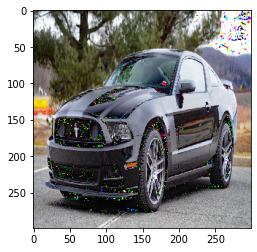

In [30]:
plt.imshow(copy_coche_2[0].astype(np.uint8))
plt.show()

from PIL import Image
# Importante guardarlo con png, si se guarda con jpg se pierde
# calidad en los píxeles y la red neuronal es capaz de identificar
# correctamente que hay en la foto
Image.fromarray(copy_coche_2[0].astype(np.uint8)).save("lemon.png")